# House Price prediction

## Building the model

### Import Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Read the data
df = pd.read_csv('train.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
df.dropna(axis=0, subset=['SalePrice'], inplace=True)

X_full =df.copy()
y = X_full.pop('SalePrice')

### Data preprocessing

In [2]:
import pandas as pd

def clean_data(df):
    # Replace missing values with "Nan" in columns: 'PoolQC', 'FireplaceQu'
    df = df.fillna({'PoolQC': "Nan", 'FireplaceQu': "Nan"})
    # Drop columns: 'MiscVal', 'MiscFeature' and 2 other columns
    df = df.drop(columns=['MiscVal', 'MiscFeature', 'Alley', 'Fence'])
    # Change column type to object for columns: 'YrSold', 'BsmtFullBath' and 6 other columns
    df = df.astype({'YrSold': 'object', 'BsmtFullBath': 'object', 'BsmtHalfBath': 'object', 'FullBath': 'object', 'HalfBath': 'object', 'KitchenAbvGr': 'object', 'GarageCars': 'object', 'Fireplaces': 'object'})
    # Change column type to int64 for columns: 'BsmtFullBath', 'BsmtHalfBath' and 5 other columns
    df = df.astype({'BsmtFullBath': 'int64', 'BsmtHalfBath': 'int64', 'FullBath': 'int64', 'HalfBath': 'int64', 'KitchenAbvGr': 'int64', 'Fireplaces': 'int64', 'GarageCars': 'int64'})
    return df

X = clean_data(X_full)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,Nan,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,Nan,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,Nan,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,Nan,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,Nan,12,2008,WD,Normal


### Feature Engineering

In [3]:
from sklearn.preprocessing import FunctionTransformer

def feature_engineering(df):
  df['HouseAge'] = df['YrSold'] - df['YearBuilt']
  df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
  df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
  

  return df

feature_eng = FunctionTransformer(feature_engineering)
X_fe = feature_eng.fit_transform(X)
X_fe.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,MoSold,YrSold,SaleType,SaleCondition,HouseAge,RemodAge,TotalSF
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,Nan,2,2008,WD,Normal,5,5,2566
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,Nan,5,2007,WD,Normal,31,31,2524
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,Nan,9,2008,WD,Normal,7,6,2706
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,Nan,2,2006,WD,Abnorml,91,36,2473
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,Nan,12,2008,WD,Normal,8,8,3343


### Define Pipelines

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Base Model
from sklearn.ensemble import RandomForestRegressor

model1 = RandomForestRegressor(n_estimators=100,
                              random_state=1
                              )


mi_selector = SelectKBest(score_func=mutual_info_regression, k=300)

# Transformers

num_cols = X_fe.select_dtypes(exclude='object').columns.tolist()
cat_cols = X_fe.select_dtypes(include='object').columns.tolist()

numerical_transformer = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler())
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

column_transformer = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols),
    ],sparse_threshold=0, remainder='passthrough')


#Preprosessor
preprosessor = Pipeline(steps=[
    ('feature_eng', feature_eng),
    ('transform', column_transformer,)
])

#pipeline
ModelPipeline = Pipeline(steps=[
    ('preprosessor', preprosessor),
    ('feateSelection', mi_selector),
    ('model', model1)
])


In [5]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2, random_state=1)

X_train_preprocessed = preprosessor.fit_transform(X_train)
X_valid_preprocessed = preprosessor.transform(X_valid)

### Train model

In [20]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.model_selection import cross_val_score

ModelPipeline.fit(X_train,y_train)
preds = ModelPipeline.predict(X_valid)
mae = mean_absolute_error(preds, y_valid)
r2 = r2_score(preds, y_valid)
mse = mean_squared_error(preds, y_valid)
print(f'mse: {mse}')
print(f'r2: {r2}')

mse: 714805057.7670921
r2: 0.8666250298256926


## Tune the model

### Finding optimal parameters

In [7]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [20, 50, 100],        # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required in a leaf node
    'bootstrap': [True, False]            # Whether bootstrap samples are used
}

grid_search = GridSearchCV(estimator=model1, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_preprocessed,y_train)

print(grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid_preprocessed)

accuracy = mean_absolute_error(y_valid, y_pred)
print(f'mae: {accuracy}')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

### Test differend models

In [8]:
X_train_xgb = pd.DataFrame(X_train_preprocessed)
X_valid_xgb = pd.DataFrame(X_valid_preprocessed)
X_train_xgb

,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,0.411765,0.214058,0.034948,0.444444,0.714286,0.202899,0.883333,0.00000,0.192062,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.191693,0.044404,0.333333,0.714286,0.202899,0.833333,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.207668,0.034901,0.666667,0.428571,0.963768,0.916667,0.00000,0.004252,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.235294,0.261981,0.046680,0.666667,0.571429,0.847826,0.650000,0.21250,0.074592,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.198083,0.028582,0.555556,0.428571,0.956522,0.900000,0.00000,0.134479,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,0.000000,0.249201,0.041319,0.555556,0.428571,0.739130,0.400000,0.10875,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1164,0.000000,0.255591,0.040291,0.444444,0.428571,0.594203,0.066667,0.06875,0.062721,0.196744,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1165,0.294118,0.191693,0.026091,0.555556,0.714286,0.304348,0.933333,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1166,0.823529,0.067093,0.001776,0.555556,0.142857,0.717391,0.350000,0.37750,0.063430,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from xgboost import XGBRegressor

model2 = XGBRegressor(n_estimators=150,
                      learning_rate=0.01,
                      early_stopping_rounds=20,
                      enable_categorical=True,
                      random_state=1)



# Fit the model
model2.fit(X_train_xgb, y_train, eval_set=[(X_valid_xgb, y_valid)], verbose=True)

[0]	validation_0-rmse:84153.38602
[1]	validation_0-rmse:83613.94682
[2]	validation_0-rmse:83052.02687
[3]	validation_0-rmse:82492.83362
[4]	validation_0-rmse:81935.66936
[5]	validation_0-rmse:81397.73995
[6]	validation_0-rmse:80854.98547
[7]	validation_0-rmse:80321.95151
[8]	validation_0-rmse:79812.74681
[9]	validation_0-rmse:79293.56364
[10]	validation_0-rmse:78784.60975
[11]	validation_0-rmse:78298.07738
[12]	validation_0-rmse:77858.67726
[13]	validation_0-rmse:77355.74864
[14]	validation_0-rmse:76938.76319
[15]	validation_0-rmse:76508.94600
[16]	validation_0-rmse:76103.97266
[17]	validation_0-rmse:75701.97805
[18]	validation_0-rmse:75292.27824
[19]	validation_0-rmse:74901.77219
[20]	validation_0-rmse:74517.92832
[21]	validation_0-rmse:74127.51646
[22]	validation_0-rmse:73748.97278
[23]	validation_0-rmse:73382.46170
[24]	validation_0-rmse:73021.20762
[25]	validation_0-rmse:72634.14019
[26]	validation_0-rmse:72278.71361
[27]	validation_0-rmse:71931.92803
[28]	validation_0-rmse:71594.3

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [11]:
y_train_np = np.array(y_train)
y_valid_np = np.array(y_valid)
y_train_np

array([145900, 106250, 164990, ..., 127000,  89500,  81000], dtype=int64)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train_t = torch.tensor(X_train_preprocessed, dtype=torch.float32)
x_valid_t = torch.tensor(X_valid_preprocessed, dtype=torch.float32)
y_train_t = torch.tensor(y_train_np, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid_np, dtype=torch.float32)

class Model_nn(nn.Module):
    def __init__(self):
        super(Model_nn, self).__init__()
        self.fc1 = nn.Linear(X_train_t.shape[1], 500)  # Input layer
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(500)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation for output
        return x

model_nn = Model_nn()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)



In [53]:
epochs = 1000
train_losses = []
valid_losses = []
for epoch in range(epochs):
    model_nn.train()
    
    # Forward pass
    predictions = model_nn(X_train_t)
    train_loss = criterion(predictions, y_train_t.view(-1, 1))
    train_losses.append(train_loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss.item()}')


# Evaluation
model_nn.eval()
with torch.no_grad():
    test_predictions = model_nn(x_valid_t)
    test_loss = criterion(test_predictions, y_valid_t.view(-1, 1))
    valid_losses.append(test_loss.item())
    print(f'Test Loss: {test_loss.item()}')


Epoch 100/1000, Loss: 117340232.0
Epoch 200/1000, Loss: 116598272.0
Epoch 300/1000, Loss: 114789864.0
Epoch 400/1000, Loss: 118616848.0
Epoch 500/1000, Loss: 140774208.0
Epoch 600/1000, Loss: 117504712.0
Epoch 700/1000, Loss: 120974352.0
Epoch 800/1000, Loss: 124778160.0
Epoch 900/1000, Loss: 117404816.0
Epoch 1000/1000, Loss: 109493336.0
Test Loss: 1042338176.0


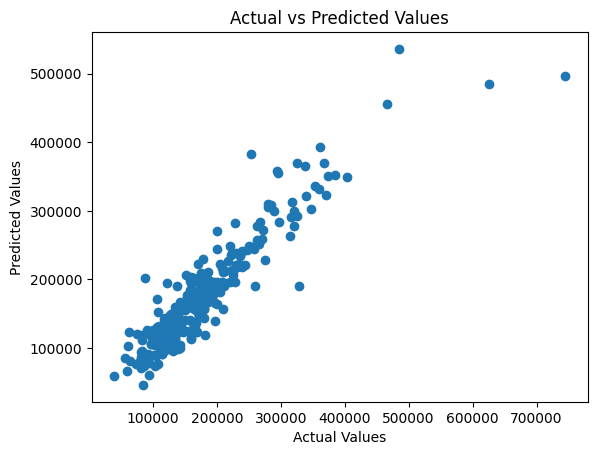

In [54]:
model_nn.eval()
with torch.no_grad():
    predictions = model_nn(x_valid_t).squeeze().numpy()

# Assuming y_valid_np is your validation target
plt.scatter(y_valid_np, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()
